# Sales Forecast Pipeline
## Objective: Predict monthly sales for each shop-item pair in November 2015

**Pipeline Overview:**
1. Data Loading & Exploration
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Model Training
5. Model Evaluation
6. Prediction on Test Set

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading

In [2]:
# Load datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
items_df = pd.read_csv('data/items.csv')
item_categories_df = pd.read_csv('data/item_categories.csv')
shops_df = pd.read_csv('data/shops.csv')

print("Data loaded successfully!")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Items shape: {items_df.shape}")
print(f"Item categories shape: {item_categories_df.shape}")
print(f"Shops shape: {shops_df.shape}")

Data loaded successfully!
Train shape: (2935849, 8)
Test shape: (214200, 3)
Items shape: (22170, 2)
Item categories shape: (84, 1)
Shops shape: (60, 1)


## 3. Exploratory Data Analysis (EDA)

### 3.1 Basic Data Overview

In [3]:
print(f"== Train df: Shape == {train_df.shape}")
# Remove redundant column
train_df = train_df.drop(columns=["Unnamed: 0"])
display(train_df.head())

print(f"== Test df: Shape == {test_df.shape}")
display(test_df.head())

print(f"== Items df: Shape == {items_df.shape}")
display(items_df.head())

print(f"== Item categories: Shape == {item_categories_df.shape}")
display(item_categories_df.head())

print(f"== Shop df: Shape == {shops_df.shape}")
display(shops_df.head())

== Train df: Shape == (2935849, 8)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56


== Test df: Shape == (214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


== Items df: Shape == (22170, 2)


,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


== Item categories: Shape == (84, 1)


,item_category_id
0,0
1,1
2,2
3,3
4,4


== Shop df: Shape == (60, 1)


,shop_id
0,0
1,1
2,2
3,3
4,4


* 2 table shop, và item_categories chỉ chứa một cột duy nhất là id, không mang thông tin nào khác nên ta có thể bỏ qua 2 table này và không cần sử dụng trong pipeline

### 3.2 Check the number of new shops/items that appear in the test set.

In [4]:
# Get unique entities
train_shops = set(train_df['shop_id'].unique())
test_shops = set(test_df['shop_id'].unique())
train_items = set(train_df['item_id'].unique())
test_items = set(test_df['item_id'].unique())

# Shops comparison
new_shops = test_shops - train_shops
print(f"SHOPS: {len(train_shops)} in train, {len(test_shops)} in test")
print(f"New shops in test: {len(new_shops)}")

# Items comparison
new_items = test_items - train_items
print(f"\nITEMS: {len(train_items)} in train, {len(test_items)} in test")
print(f"New items in test: {len(new_items)} ({len(new_items)/len(test_items)*100:.1f}%)")

# (Shop, Item) pairs comparison
train_pairs = set(zip(train_df['shop_id'], train_df['item_id']))
test_pairs = set(zip(test_df['shop_id'], test_df['item_id']))
new_pairs = test_pairs - train_pairs

print(f"\n(SHOP, ITEM) PAIRS: {len(train_pairs):,} in train, {len(test_pairs):,} in test")
print(f"New pairs in test: {len(new_pairs):,} ({len(new_pairs)/len(test_pairs)*100:.1f}%)")

SHOPS: 60 in train, 42 in test
New shops in test: 0

ITEMS: 21807 in train, 5100 in test
New items in test: 363 (7.1%)

(SHOP, ITEM) PAIRS: 424,124 in train, 214,200 in test
New pairs in test: 102,796 (48.0%)


* Almost half of the (shop, item) combinations in the test set are unseen during training.
* This leads to a cold-start problem, where many series have little or no historical observations.
* In such scenarios, traditional univariate time-series models like ARIMA or Prophet are not appropriate, since they rely heavily on the past behavior of each individual series.
* Instead, a global model that can leverage cross-sectional features across shops and items is more suitable.

### 3.3 Check data quality

In [5]:
# Check missing values
print("\nMissing values in train:")
print(train_df.isnull().sum())
print("\nMissing values in test:")
print(test_df.isnull().sum())


Missing values in train:
date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
dtype: int64

Missing values in test:
ID         0
shop_id    0
item_id    0
dtype: int64


In [6]:
# Check data types
print("\nData types in train:")
print(train_df.dtypes)
print("\nData types in test:")
print(test_df.dtypes)


Data types in train:
date                 object
date_block_num        int64
shop_id               int64
item_id               int64
item_price          float64
item_cnt_day        float64
item_category_id      int64
dtype: object

Data types in test:
ID         int64
shop_id    int64
item_id    int64
dtype: object


### 3.4 Target Variable Analysis (item_cnt_day)

Analyze the distribution of daily sales to understand patterns, outliers, and data quality issues.

TARGET VARIABLE: item_cnt_day

Basic statistics:
count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

Negative values (returns): 7,356 (0.25%)
Min value: -22.0

Percentile analysis:
  95.0th percentile: 2.0
  99.0th percentile: 5.0
  99.9th percentile: 22.0
Max value: 2169.0


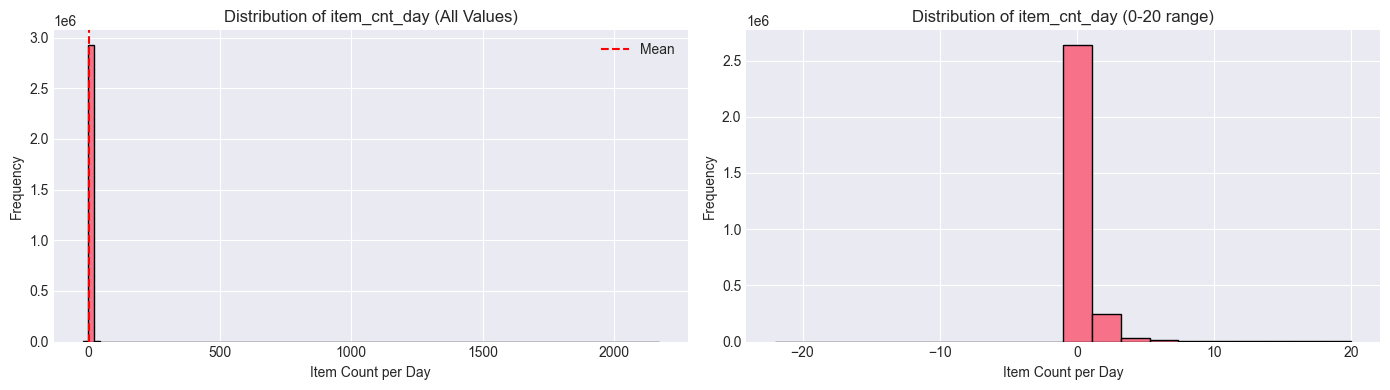

In [7]:
# Statistical summary
print("TARGET VARIABLE: item_cnt_day")
print("\nBasic statistics:")
print(train_df['item_cnt_day'].describe())

# Check for negative values (returns/refunds)
negative_count = (train_df['item_cnt_day'] < 0).sum()
print(f"\nNegative values (returns): {negative_count:,} ({negative_count/len(train_df)*100:.2f}%)")
print(f"Min value: {train_df['item_cnt_day'].min()}")

# Check extreme values
print(f"\nPercentile analysis:")
for p in [0.95, 0.99, 0.999]:
    val = train_df['item_cnt_day'].quantile(p)
    print(f"  {p*100:.1f}th percentile: {val:.1f}")
print(f"Max value: {train_df['item_cnt_day'].max()}")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(train_df['item_cnt_day'], bins=100, edgecolor='black')
axes[0].set_xlabel('Item Count per Day')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of item_cnt_day (All Values)')
axes[0].axvline(train_df['item_cnt_day'].mean(), color='r', linestyle='--', label='Mean')
axes[0].legend()

# Focus on typical range
axes[1].hist(train_df[train_df['item_cnt_day'] <= 20]['item_cnt_day'], bins=20, edgecolor='black')
axes[1].set_xlabel('Item Count per Day')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of item_cnt_day (0-20 range)')

plt.tight_layout()
plt.show()

* Hầu hết các item có số lượng được bán ra không quá lớn (99.9th percentile: 22) trong khi đó max value = 2169, vậy nên các recored có `item_cnt_day` lớn có thể được loại bỏ như outlier, ta sẽ xem xét kĩ hơn vấn đề này ở phần data processing

In [8]:
# Check records have item_cnt_day < 0
negative_records = train_df[train_df['item_cnt_day'] < 0]
print(f"Number of records with item_cnt_day < 0: {len(negative_records):,}")
print(f"Percentage of records with item_cnt_day < 0: {len(negative_records)/len(train_df)*100:.2f}%")
display(negative_records.head())

Number of records with item_cnt_day < 0: 7,356
Percentage of records with item_cnt_day < 0: 0.25%


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2,05.01.2013,0,25,2552,899.0,-1.0,58
148,23.01.2013,0,25,2321,999.0,-1.0,28
175,07.01.2013,0,25,2199,1449.0,-1.0,58
807,02.01.2013,0,25,2330,599.0,-1.0,30
1041,13.01.2013,0,25,5034,1989.0,-1.0,23


**Understanding negative values:**
Vì cột `item_cnt_day` thể hiện số lượng item được bán ra trong một ngày, vậy nên giá trị âm có thể được hiểu là số lượng item bị trả  về shop, vì cần dự báo số lượng item bán ra trong cả tháng nên có thể cân nhắc loại bỏ các record có `item_cnt_day` < 0.

### 3.5 Price Variable Analysis (item_price)

Check price distribution and identify anomalies that may require cleaning.

PRICE ANALYSIS

Basic statistics:
count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

Price = 0: 0 (0.00%)
Price < 0: 1

Percentile analysis:
  95.0th percentile: 2690.0
  99.0th percentile: 5999.0
  99.9th percentile: 23990.0
Max price: 307980.0


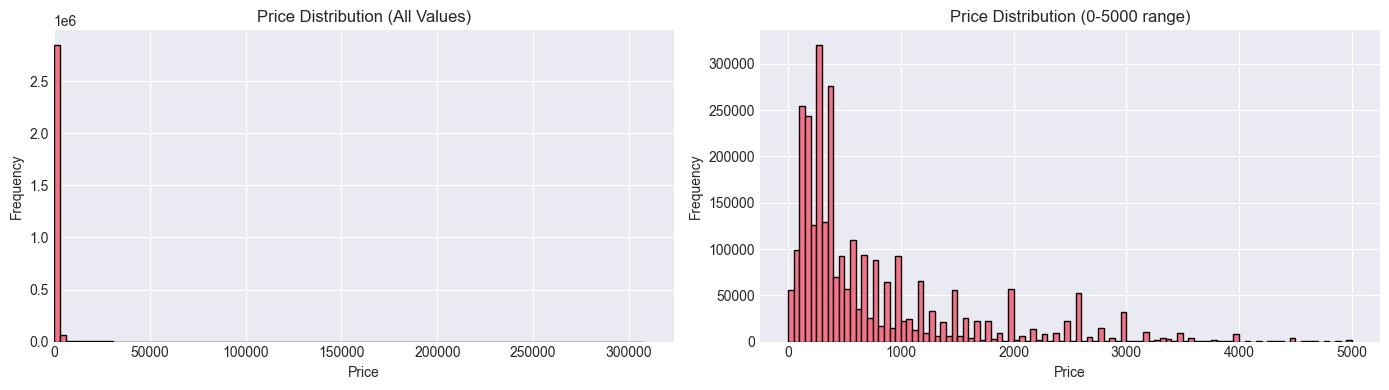

In [9]:
# Price statistics
print("PRICE ANALYSIS")
print("\nBasic statistics:")
print(train_df['item_price'].describe())

# Check for anomalies
zero_price = (train_df['item_price'] == 0).sum()
negative_price = (train_df['item_price'] < 0).sum()
print(f"\nPrice = 0: {zero_price:,} ({zero_price/len(train_df)*100:.2f}%)")
print(f"Price < 0: {negative_price:,}")

# Extreme prices
print(f"\nPercentile analysis:")
for p in [0.95, 0.99, 0.999]:
    val = train_df['item_price'].quantile(p)
    print(f"  {p*100:.1f}th percentile: {val:.1f}")
print(f"Max price: {train_df['item_price'].max():.1f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(train_df['item_price'], bins=100, edgecolor='black')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (All Values)')
axes[0].set_xlim(left=0)

# Focus on typical price range
axes[1].hist(train_df[train_df['item_price'] <= 5000]['item_price'], bins=100, edgecolor='black')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (0-5000 range)')

plt.tight_layout()
plt.show()

* Một có 1 trường hợp price < 0 -> Loại bỏ 
* Hầu hết các items có giá thấp, một số ít items có giá rất cao

### 3.6 Temporal Patterns

Analyze sales trends over time to understand seasonality and inform lag feature design.

TEMPORAL PATTERNS

Total months: 34
Date range: 2013-01-01 00:00:00 to 2015-10-31 00:00:00


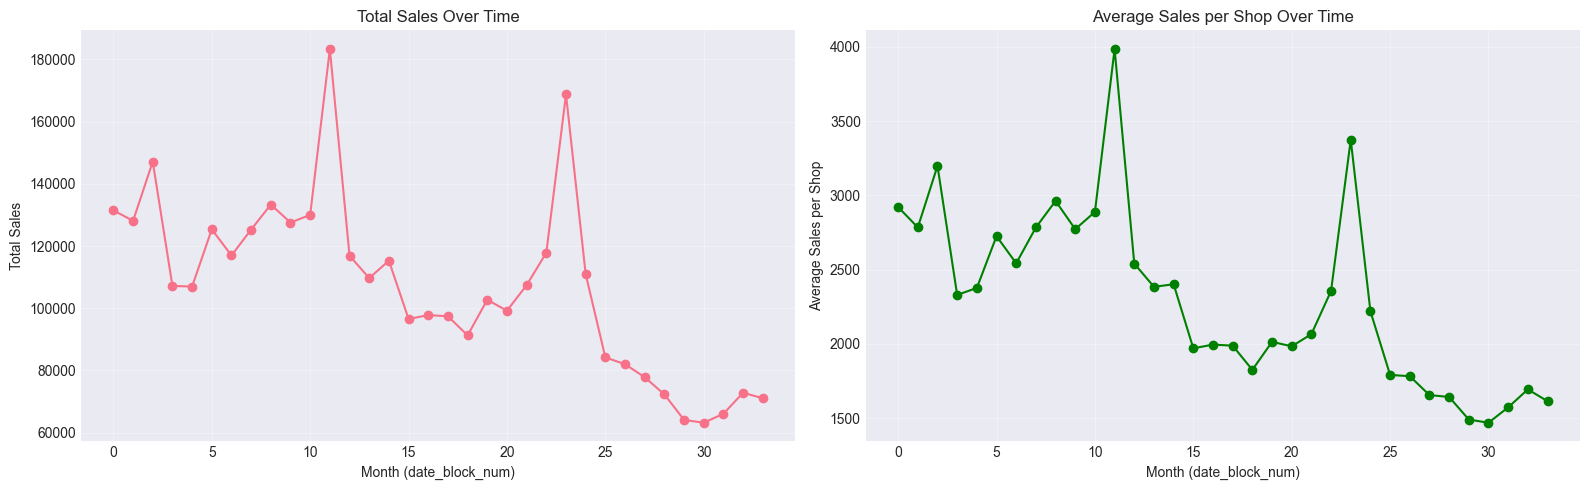


Monthly sales variation:
  Min month sales: 63,187
  Max month sales: 183,342
  Coefficient of Variation: 0.27

Number of active shops:
  Min shops: 42
  Max shops: 52
  Average shops per month: 46.6


In [10]:
# Parse date if not already done
train_df['date'] = pd.to_datetime(train_df['date'], format='%d.%m.%Y')

# Aggregate sales by month
monthly_sales = train_df.groupby('date_block_num')['item_cnt_day'].sum().reset_index()
monthly_sales.columns = ['month', 'total_sales']

# Calculate number of active shops per month and average sales per shop
shops_per_month = train_df.groupby('date_block_num')['shop_id'].nunique().reset_index()
shops_per_month.columns = ['month', 'n_shops']
monthly_sales = monthly_sales.merge(shops_per_month, on='month')
monthly_sales['avg_sales_per_shop'] = monthly_sales['total_sales'] / monthly_sales['n_shops']

print("TEMPORAL PATTERNS")
print(f"\nTotal months: {train_df['date_block_num'].nunique()}")
print(f"Date range: {train_df['date'].min()} to {train_df['date'].max()}")

# Visualize trends
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Total sales over time
axes[0].plot(monthly_sales['month'], monthly_sales['total_sales'], marker='o')
axes[0].set_xlabel('Month (date_block_num)')
axes[0].set_ylabel('Total Sales')
axes[0].set_title('Total Sales Over Time')
axes[0].grid(True, alpha=0.3)

# Average sales per shop over time
axes[1].plot(monthly_sales['month'], monthly_sales['avg_sales_per_shop'], marker='o', color='green')
axes[1].set_xlabel('Month (date_block_num)')
axes[1].set_ylabel('Average Sales per Shop')
axes[1].set_title('Average Sales per Shop Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check seasonality hint
print("\nMonthly sales variation:")
print(f"  Min month sales: {monthly_sales['total_sales'].min():,.0f}")
print(f"  Max month sales: {monthly_sales['total_sales'].max():,.0f}")
print(f"  Coefficient of Variation: {(monthly_sales['total_sales'].std() / monthly_sales['total_sales'].mean()):.2f}")

print(f"\nNumber of active shops:")
print(f"  Min shops: {monthly_sales['n_shops'].min()}")
print(f"  Max shops: {monthly_sales['n_shops'].max()}")
print(f"  Average shops per month: {monthly_sales['n_shops'].mean():.1f}")

* Nhìn chung có xu hướng giảm, và có 2 đỉnh rõ rệt là vào tháng 12/2013 và 12/2024, đây là thời điểm của dịp Giáng sinh nên doanh số tăng mạnh

### 3.7 Data Sparsity Analysis

Understand how sparse the data is - most shop-item-date combinations likely have zero sales.

In [11]:
# Calculate possible combinations
n_shops = train_df['shop_id'].nunique()
n_items = train_df['item_id'].nunique()
n_dates = train_df['date'].nunique()
n_months = train_df['date_block_num'].nunique()

# Daily level
possible_daily = n_shops * n_items * n_dates
actual_daily = len(train_df)

# Monthly level (aggregated)
actual_monthly = train_df.groupby(['date_block_num', 'shop_id', 'item_id']).size().shape[0]
possible_monthly = n_shops * n_items * n_months

print("DATA SPARSITY ANALYSIS")
print("\nDaily level:")
print(f"  Possible combinations: {possible_daily:,}")
print(f"  Actual records: {actual_daily:,}")
print(f"  Density: {actual_daily/possible_daily*100:.4f}%")

print("\nMonthly level (aggregated):")
print(f"  Possible combinations: {possible_monthly:,}")
print(f"  Actual records: {actual_monthly:,}")
print(f"  Density: {actual_monthly/possible_monthly*100:.2f}%")

DATA SPARSITY ANALYSIS

Daily level:
  Possible combinations: 1,352,906,280
  Actual records: 2,935,849
  Density: 0.2170%

Monthly level (aggregated):
  Possible combinations: 44,486,280
  Actual records: 1,609,124
  Density: 3.62%


* Implication: Data is highly sparse - most shop-item combinations have no sales.
* Strategy: Aggregate to monthly level and use category/shop/item averages as features.

### 3.8 Category Distribution Analysis

Understand which categories drive sales - important for category-level features.

CATEGORY ANALYSIS

Total categories: 84

Top 10 categories by sales volume:
 category_id  total_sales  n_items
          40     634171.0     4964
          30     456540.0      751
          55     348591.0     2327
          19     254887.0      625
          37     203284.0     1777
          71     187998.0        6
          28     174954.0      235
          23     169944.0      496
          20     127319.0      157
          65      73077.0      151


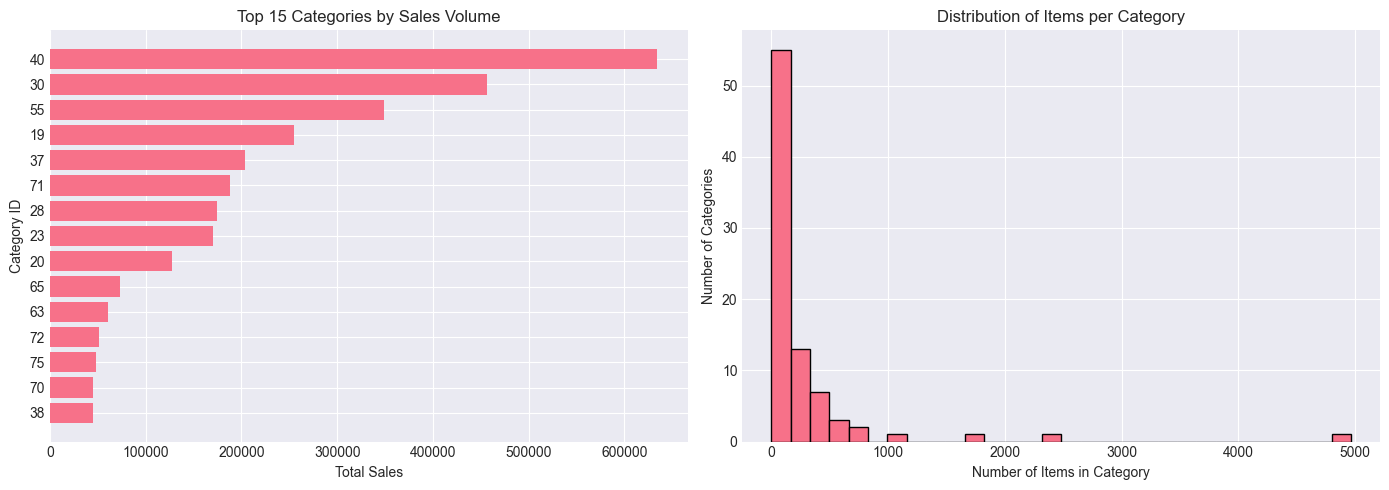


Top 10 categories account for 72.1% of total sales


In [12]:
# Category statistics (train_df already has item_category_id from items merge)
cat_sales = train_df.groupby('item_category_id').agg({
    'item_cnt_day': 'sum',
    'item_id': 'nunique'
}).reset_index()
cat_sales.columns = ['category_id', 'total_sales', 'n_items']
cat_sales = cat_sales.sort_values('total_sales', ascending=False)

print("CATEGORY ANALYSIS")
print(f"\nTotal categories: {train_df['item_category_id'].nunique()}")
print(f"\nTop 10 categories by sales volume:")
print(cat_sales.head(10).to_string(index=False))

# Visualize top categories
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Top 15 categories by sales
top_cats = cat_sales.head(15)
axes[0].barh(range(len(top_cats)), top_cats['total_sales'])
axes[0].set_yticks(range(len(top_cats)))
axes[0].set_yticklabels(top_cats['category_id'])
axes[0].set_xlabel('Total Sales')
axes[0].set_ylabel('Category ID')
axes[0].set_title('Top 15 Categories by Sales Volume')
axes[0].invert_yaxis()

# Number of items per category
axes[1].hist(cat_sales['n_items'], bins=30, edgecolor='black')
axes[1].set_xlabel('Number of Items in Category')
axes[1].set_ylabel('Number of Categories')
axes[1].set_title('Distribution of Items per Category')

plt.tight_layout()
plt.show()

# Sales concentration
top_10_pct = cat_sales.head(10)['total_sales'].sum() / cat_sales['total_sales'].sum() * 100
print(f"\nTop 10 categories account for {top_10_pct:.1f}% of total sales")

## 4. Data Preprocessing

### 4.1 Data Cleaning

Remove outliers and invalid records to improve model quality.
* Đối với outliers, vì distribution của `item_cnt_day` không quá phức tạp hầu như chỉ tập trung quanh một khoảng giá trị rất nhỏ vậy nên chỉ cần loại bỏ các giá trị âm hoặc rất lớn, không cần dùng các phương pháp như Z-Score hay IQR ...

In [13]:
# Data cleaning
print("Before cleaning:")
print(f"  Total records: {len(train_df):,}")
print(f"  Negative item_cnt_day: {(train_df['item_cnt_day'] < 0).sum():,}")
print(f"  Extreme item_cnt_day (>1000): {(train_df['item_cnt_day'] > 1000).sum():,}")
print(f"  Zero/negative prices: {(train_df['item_price'] <= 0).sum():,}")

# Remove problematic records
train_clean = train_df[
    (train_df['item_cnt_day'] >= 0) &  # Remove returns
    (train_df['item_cnt_day'] <= 1000) &  # Remove extreme outliers
    (train_df['item_price'] > 0)  # Remove invalid prices
].copy()

print(f"\nAfter cleaning:")
print(f"  Total records: {len(train_clean):,}")
print(f"  Records removed: {len(train_df) - len(train_clean):,} ({(len(train_df) - len(train_clean))/len(train_df)*100:.2f}%)")

# Update train reference
train_df = train_clean
del train_clean

Before cleaning:
  Total records: 2,935,849
  Negative item_cnt_day: 7,356
  Extreme item_cnt_day (>1000): 1
  Zero/negative prices: 1

After cleaning:
  Total records: 2,928,491
  Records removed: 7,358 (0.25%)


### 4.2 Aggregate to Monthly Level

Convert daily sales data to monthly aggregates. The target is to predict **monthly** sales (item_cnt_month), not daily.

In [14]:
# Aggregate daily sales to monthly level
monthly_data = train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_cnt_day': 'sum',  # Total monthly sales
    'item_price': 'mean'     # Average price in the month
}).reset_index()

# Rename target column
monthly_data.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

print("Monthly aggregation complete:")
print(f"  Daily records: {len(train_df):,}")
print(f"  Monthly records: {len(monthly_data):,}")
print(f"\nMonthly data sample:")
display(monthly_data.head(10))

Monthly aggregation complete:
  Daily records: 2,928,491
  Monthly records: 1,608,226

Monthly data sample:


,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5
5,0,0,61,1.0,195.0
6,0,0,75,1.0,76.0
7,0,0,88,1.0,76.0
8,0,0,95,1.0,193.0
9,0,0,96,1.0,70.0


### 4.2.1 Check Shop Activity Over Time

Some shops may only have data for early months and then disappear (closed shops) example shop id 0. We should analyze this.

In [15]:
monthly_data[monthly_data['shop_id'] == 0]['date_block_num'].unique()

array([0, 1])

Shop Activity Analysis:

Total unique shops: 60

Shops that stopped appearing before month 10: 5
Sample of early-disappearing shops:
    shop_id  first_month  last_month  n_records
0         0            0           1       4821
1         1            0           1       3282
8         8            0           2       2463
23       23            0           3       4425
32       32            0           6       5521

Shops active in recent months (>=30): 46

Early-disappearing shops that appear in TEST set: 0
  -> None


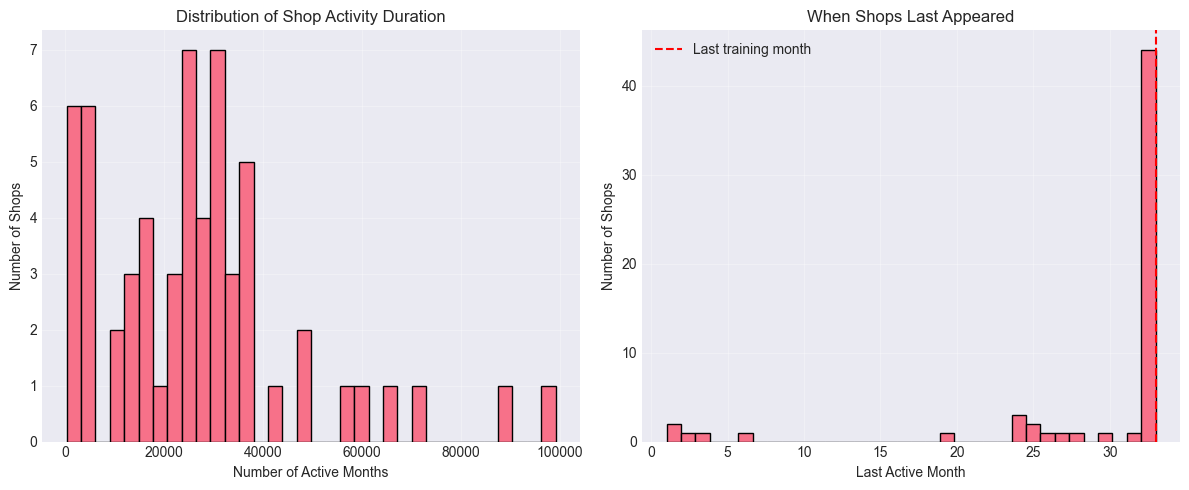

In [16]:
# Analyze shop activity over time
shop_activity = monthly_data.groupby('shop_id')['date_block_num'].agg(['min', 'max', 'count']).reset_index()
shop_activity.columns = ['shop_id', 'first_month', 'last_month', 'n_records']

print("Shop Activity Analysis:")
print(f"\nTotal unique shops: {len(shop_activity)}")

# Find shops that disappeared early
early_disappear = shop_activity[shop_activity['last_month'] < 10]  # Stopped before month 10
print(f"\nShops that stopped appearing before month 10: {len(early_disappear)}")
if len(early_disappear) > 0:
    print("Sample of early-disappearing shops:")
    print(early_disappear.head(10))

# Shops active in recent months (likely in test set)
recent_active = shop_activity[shop_activity['last_month'] >= 30]  # Active in last 4 months
print(f"\nShops active in recent months (>=30): {len(recent_active)}")

# Check if these shops are in test set
test_shops = set(test_df['shop_id'].unique())
early_shops = set(early_disappear['shop_id'])
overlap = early_shops & test_shops

print(f"\nEarly-disappearing shops that appear in TEST set: {len(overlap)}")
print(f"  -> {list(overlap)[:10] if len(overlap) > 0 else 'None'}")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(shop_activity['n_records'], bins=34, edgecolor='black')
plt.xlabel('Number of Active Months')
plt.ylabel('Number of Shops')
plt.title('Distribution of Shop Activity Duration')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(shop_activity['last_month'], bins=34, edgecolor='black')
plt.xlabel('Last Active Month')
plt.ylabel('Number of Shops')
plt.title('When Shops Last Appeared')
plt.axvline(x=33, color='r', linestyle='--', label='Last training month')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

* Có 5 shop đóng cửa sau 6 tháng đầu tiên của dữ liệu, các shop này cũng không tồn tại trong test set. Tạm thời với baseline thì sẽ giữ lại data của các shop này, tuy nhiên khi impove model trong tương lai thì có thể phân thích lại để xử lí.

Monthly sales statistics:
count    1.608226e+06
mean     2.271806e+00
std      8.469517e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.644000e+03
Name: item_cnt_month, dtype: float64

Percentile analysis:
  95.0th percentile: 6.0
  99.0th percentile: 17.0
  99.9th percentile: 74.0


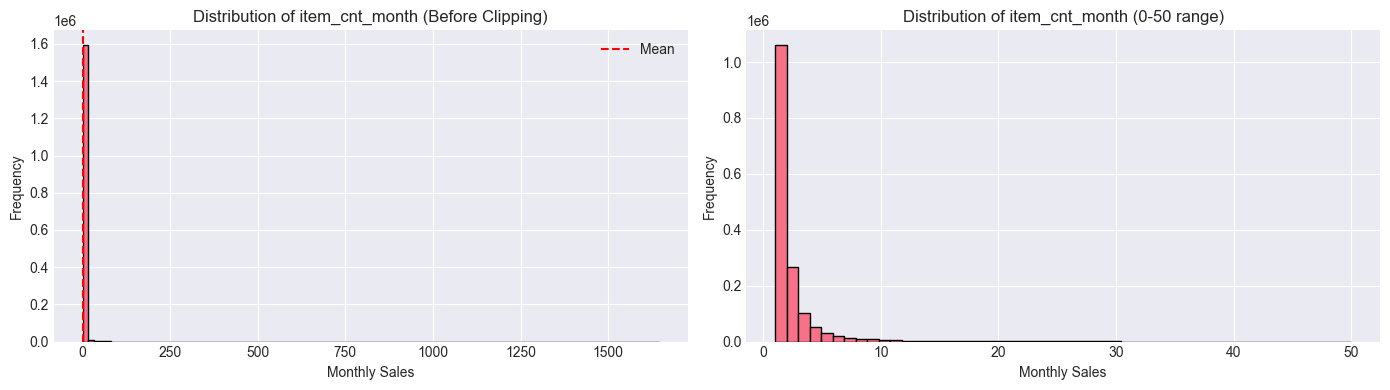

In [17]:
# Check monthly target distribution
print("Monthly sales statistics:")
print(monthly_data['item_cnt_month'].describe())

print(f"\nPercentile analysis:")
for p in [0.95, 0.99, 0.999]:
    val = monthly_data['item_cnt_month'].quantile(p)
    print(f"  {p*100:.1f}th percentile: {val:.1f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(monthly_data['item_cnt_month'], bins=100, edgecolor='black')
axes[0].set_xlabel('Monthly Sales')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of item_cnt_month (Before Clipping)')
axes[0].axvline(monthly_data['item_cnt_month'].mean(), color='r', linestyle='--', label='Mean')
axes[0].legend()

# Focus on 0-50 range
axes[1].hist(monthly_data[monthly_data['item_cnt_month'] <= 50]['item_cnt_month'], bins=50, edgecolor='black')
axes[1].set_xlabel('Monthly Sales')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of item_cnt_month (0-50 range)')

plt.tight_layout()
plt.show()

### 4.3 Clip Target Variable
* Trong bài toán thực tế của doanh nghiệp, việc clip ground truth hay nói rộng hơn là xử lí dữ liệu phụ thuộc vào mục đích cuối cùng của việc dự báo là gì.
* Nếu như mục đích dự báo là để xác định các thời điểm mà đơn hàng tăng đột biến thì số lượng đơn hàng là bao nhiêu để có phương án xử lí phù hợp tránh việc bể vận hành (đặc biệt trong logistic) thì không nên clip và có thể chấp nhận đánh đổi độ chính xác trung bình để lấy khả năng dự báo tốt hơn vào các ngày even, ngày lễ.
* Tuy nhiên trong bài này ta không có context về bussiness cụ thể, vậy nên để đơn giản solution ta vẫn sẽ clip ground truth

Before clipping:
  Min: 1.0
  Max: 1644.0
  Values > 20: 11,475

After clipping to [0, 20]:
  Min: 1.0
  Max: 20.0


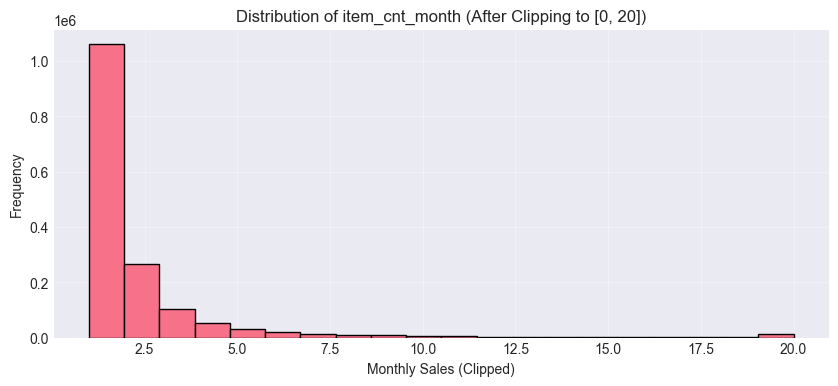

In [18]:
# 99th percentile is around 17
# Clip target to [0, 20] range
print("Before clipping:")
print(f"  Min: {monthly_data['item_cnt_month'].min():.1f}")
print(f"  Max: {monthly_data['item_cnt_month'].max():.1f}")
print(f"  Values > 20: {(monthly_data['item_cnt_month'] > 20).sum():,}")

monthly_data['item_cnt_month'] = monthly_data['item_cnt_month'].clip(0, 20)

print(f"\nAfter clipping to [0, 20]:")
print(f"  Min: {monthly_data['item_cnt_month'].min():.1f}")
print(f"  Max: {monthly_data['item_cnt_month'].max():.1f}")

# Visualize after clipping
plt.figure(figsize=(10, 4))
plt.hist(monthly_data['item_cnt_month'], bins=20, edgecolor='black')
plt.xlabel('Monthly Sales (Clipped)')
plt.ylabel('Frequency')
plt.title('Distribution of item_cnt_month (After Clipping to [0, 20])')
plt.grid(True, alpha=0.3)
plt.show()

### 4.4 Summary of Preprocessing

Review the final preprocessed dataset before feature engineering.

In [19]:
# Final preprocessed data summary
print("="*60)
print("PREPROCESSING COMPLETE")
print("="*60)

print(f"\nFinal monthly dataset:")
print(f"  Shape: {monthly_data.shape}")
print(f"  Date range: month {monthly_data['date_block_num'].min()} to {monthly_data['date_block_num'].max()}")
print(f"  Unique shops: {monthly_data['shop_id'].nunique()}")
print(f"  Unique items: {monthly_data['item_id'].nunique()}")
print(f"  Unique (shop, item) pairs: {monthly_data.groupby(['shop_id', 'item_id']).ngroups:,}")

print(f"\nTarget variable (item_cnt_month):")
print(f"  Mean: {monthly_data['item_cnt_month'].mean():.2f}")
print(f"  Median: {monthly_data['item_cnt_month'].median():.2f}")
print(f"  Std: {monthly_data['item_cnt_month'].std():.2f}")

print(f"\nData sample:")
display(monthly_data.head())


PREPROCESSING COMPLETE

Final monthly dataset:
  Shape: (1608226, 5)
  Date range: month 0 to 33
  Unique shops: 60
  Unique items: 21804
  Unique (shop, item) pairs: 424,098

Target variable (item_cnt_month):
  Mean: 2.03
  Median: 1.00
  Std: 2.58

Data sample:


,date_block_num,shop_id,item_id,item_cnt_month,item_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


## 5. Feature Engineering

Feature engineering is critical for time series forecasting. We'll create features that capture:
- **Temporal patterns**: Lag features from previous months
- **Aggregated statistics**: Shop/item/category averages
- **Trend indicators**: Rolling means and momentum
- **Cold start handling**: Fill missing values for new items/shops

### 5.1 Create Sparse Grid with Time Windows

Create a **sparse grid** that only includes (shop, item) pairs that had at least one sale in training data, and only within their active time window [first_appearance, last_appearance].

In [20]:
# Step 1: Identify active time window for each (shop, item) pair
print("Creating SPARSE grid with time windows...")
print("="*60)

# Get first and last appearance for each pair
pair_ranges = monthly_data.groupby(['shop_id', 'item_id'])['date_block_num'].agg(['min', 'max']).reset_index()
pair_ranges.columns = ['shop_id', 'item_id', 'first_month', 'last_month']

print(f"Active (shop, item) pairs: {len(pair_ranges):,}")
print(f"Total possible pairs: {monthly_data['shop_id'].nunique() * monthly_data['item_id'].nunique():,}")
print(f"Coverage: {len(pair_ranges) / (monthly_data['shop_id'].nunique() * monthly_data['item_id'].nunique()) * 100:.2f}%")

# Step 2: Create sparse grid - only for active pairs within their time windows
print(f"\nBuilding sparse grid...")
grid_rows = []

for _, row in pair_ranges.iterrows():
    shop_id = row['shop_id']
    item_id = row['item_id']
    first_month = row['first_month']
    last_month = row['last_month']
    
    # Create entries for all months in [first_month, last_month]
    for month in range(first_month, last_month + 1):
        grid_rows.append([month, shop_id, item_id])

grid = pd.DataFrame(grid_rows, columns=['date_block_num', 'shop_id', 'item_id'])
print(f"Sparse grid shape: {grid.shape}")

# Step 3: Merge with monthly_data to get actual sales
grid = grid.merge(monthly_data, on=['date_block_num', 'shop_id', 'item_id'], how='left')

# Fill missing months within time window with 0 (real gaps, not artificial)
grid['item_cnt_month'] = grid['item_cnt_month'].fillna(0).clip(0, 20)

# Step 4: Sort and fill missing prices
grid = grid.sort_values(['shop_id', 'item_id', 'date_block_num'])

# Forward/backward fill prices within each (shop, item) pair
grid['item_price'] = grid.groupby(['shop_id', 'item_id'])['item_price'].fillna(method='ffill').fillna(method='bfill')

# If still NaN (rare), use item's global mean price
grid['item_price'] = grid['item_price'].fillna(grid.groupby('item_id')['item_price'].transform('mean'))

# Step 5: Analyze sparsity and display statistics
print("\n" + "="*60)
print("SPARSE GRID STATISTICS:")
print("="*60)

total_rows = len(grid)
nonzero_sales = (grid['item_cnt_month'] > 0).sum()
sparsity_pct = nonzero_sales / total_rows * 100

print(f"Total rows: {total_rows:,}")
print(f"Non-zero sales: {nonzero_sales:,} ({sparsity_pct:.2f}%)")
print(f"Zero sales (real gaps): {total_rows - nonzero_sales:,} ({100-sparsity_pct:.2f}%)")
print(f"Memory usage: {grid.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"Reduction vs full grid: {(1 - total_rows / (34 * 60 * 22170)) * 100:.1f}%")
print("="*60)

Creating SPARSE grid with time windows...
Active (shop, item) pairs: 424,098
Total possible pairs: 1,308,240
Coverage: 32.42%

Building sparse grid...
Sparse grid shape: (3194435, 3)

SPARSE GRID STATISTICS:
Total rows: 3,194,435
Non-zero sales: 1,608,226 (50.34%)
Zero sales (real gaps): 1,586,209 (49.66%)
Memory usage: 121.9 MB
Reduction vs full grid: 92.9%


In [21]:
# Check sample of grid
grid[
    (grid['shop_id'] == 30) &
    (grid['item_id'] == 32)
].head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price
1499065,0,30,32,9.0,349.0
1499066,1,30,32,4.0,349.0
1499067,2,30,32,2.0,349.0
1499068,3,30,32,1.0,349.0
1499069,4,30,32,1.0,349.0
1499070,5,30,32,0.0,349.0
1499071,6,30,32,1.0,349.0
1499072,7,30,32,1.0,349.0
1499073,8,30,32,2.0,349.0
1499074,9,30,32,0.0,349.0


### 5.2 Lag Features

Lag features capture historical sales patterns. We create lags at different time horizons:
- **Recent lags (1, 2, 3 months)**: Capture short-term trends and seasonality
- **Medium-term lag (6 months)**: Capture semi-annual patterns
- **Long-term lag (12 months)**: Capture yearly seasonality

In [22]:
# Sort by date for correct lag calculation
grid = grid.sort_values(['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True)

# Create lag features
lag_periods = [1, 2, 3, 6, 12]

for lag in lag_periods:
    print(f"Creating lag_{lag} feature...")
    grid[f'item_cnt_lag_{lag}'] = grid.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)

# Fill NaN lags with 0 (for new items or early months)
lag_cols = [f'item_cnt_lag_{lag}' for lag in lag_periods]
grid[lag_cols] = grid[lag_cols].fillna(0)

print(f"\nLag features created: {lag_cols}")
print(f"Grid shape after lags: {grid.shape}")

Creating lag_1 feature...
Creating lag_2 feature...
Creating lag_3 feature...
Creating lag_6 feature...
Creating lag_12 feature...

Lag features created: ['item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3', 'item_cnt_lag_6', 'item_cnt_lag_12']
Grid shape after lags: (3194435, 10)


In [23]:
grid[
    (grid['shop_id'] == 30) &
    (grid['item_id'] == 32)
].head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_lag_1,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_6,item_cnt_lag_12
1499065,0,30,32,9.0,349.0,0.0,0.0,0.0,0.0,0.0
1499066,1,30,32,4.0,349.0,9.0,0.0,0.0,0.0,0.0
1499067,2,30,32,2.0,349.0,4.0,9.0,0.0,0.0,0.0
1499068,3,30,32,1.0,349.0,2.0,4.0,9.0,0.0,0.0
1499069,4,30,32,1.0,349.0,1.0,2.0,4.0,0.0,0.0


### 5.3 Rolling Mean Features

Rolling means smooth out noise and capture trends:
- **3-month rolling mean**: Recent trend
- **6-month rolling mean**: Medium-term trend
- **12-month rolling mean**: Long-term trend

In [24]:
# Create rolling mean features
rolling_windows = [3, 6, 12]

for window in rolling_windows:
    print(f"Creating {window}-month rolling mean...")
    # Apply rolling mean on grouped data, then shift to avoid leakage
    grid[f'item_cnt_rolling_mean_{window}'] = (
        grid.groupby(['shop_id', 'item_id'])['item_cnt_month']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    )

# Fill NaN with 0
rolling_cols = [f'item_cnt_rolling_mean_{w}' for w in rolling_windows]
grid[rolling_cols] = grid[rolling_cols].fillna(0)

print(f"\nRolling mean features created: {rolling_cols}")
print(f"Grid shape: {grid.shape}")

Creating 3-month rolling mean...
Creating 6-month rolling mean...
Creating 12-month rolling mean...

Rolling mean features created: ['item_cnt_rolling_mean_3', 'item_cnt_rolling_mean_6', 'item_cnt_rolling_mean_12']
Grid shape: (3194435, 13)


In [25]:
# grid[
#     (grid['shop_id'] == 30) &
#     (grid['item_id'] == 32)
# ].head()

### 5.4 Aggregated Features

Aggregated features capture average behavior at different granularities:
- **Shop-level**: Average sales per shop (shop popularity)
- **Item-level**: Average sales per item (item popularity)
- **Category-level**: Average sales per category (category trends)

In [26]:
# Add item_category_id to grid
grid = grid.merge(items_df[['item_id', 'item_category_id']], on='item_id', how='left')

# Shop-level aggregations (use previous month to avoid leakage)
print("Creating shop-level aggregations...")
shop_agg = grid.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].mean().reset_index()
shop_agg.columns = ['date_block_num', 'shop_id', 'shop_avg_item_cnt']
shop_agg['date_block_num'] += 1  # Shift forward by 1 month
grid = grid.merge(shop_agg, on=['date_block_num', 'shop_id'], how='left')

# Item-level aggregations
print("Creating item-level aggregations...")
item_agg = grid.groupby(['date_block_num', 'item_id'])['item_cnt_month'].mean().reset_index()
item_agg.columns = ['date_block_num', 'item_id', 'item_avg_cnt']
item_agg['date_block_num'] += 1
grid = grid.merge(item_agg, on=['date_block_num', 'item_id'], how='left')

# Category-level aggregations
print("Creating category-level aggregations...")
cat_agg = grid.groupby(['date_block_num', 'item_category_id'])['item_cnt_month'].mean().reset_index()
cat_agg.columns = ['date_block_num', 'item_category_id', 'category_avg_cnt']
cat_agg['date_block_num'] += 1
grid = grid.merge(cat_agg, on=['date_block_num', 'item_category_id'], how='left')

# Fill NaN with 0 (for first month or new entities)
agg_cols = ['shop_avg_item_cnt', 'item_avg_cnt', 'category_avg_cnt']
grid[agg_cols] = grid[agg_cols].fillna(0)

print(f"\nAggregated features created: {agg_cols}")
print(f"Grid shape: {grid.shape}")

Creating shop-level aggregations...
Creating item-level aggregations...
Creating category-level aggregations...

Aggregated features created: ['shop_avg_item_cnt', 'item_avg_cnt', 'category_avg_cnt']
Grid shape: (3194435, 17)


### 5.5 Trend Features

Trend features capture momentum and direction of sales changes:
- **Delta features**: Change from previous month
- **Trend indicator**: Whether sales are increasing or decreasing

In [27]:
# Delta from previous month
print("Creating trend features...")
grid['item_cnt_delta_1'] = grid['item_cnt_lag_1'] - grid['item_cnt_lag_2']

# Create additional lags if needed for momentum calculation
if 'item_cnt_lag_4' not in grid.columns:
    grid['item_cnt_lag_4'] = grid.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(4).fillna(0)
if 'item_cnt_lag_5' not in grid.columns:
    grid['item_cnt_lag_5'] = grid.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(5).fillna(0)

# Momentum (avg of last 3 months - avg of months 4-6)
grid['item_cnt_momentum'] = (
    (grid['item_cnt_lag_1'] + grid['item_cnt_lag_2'] + grid['item_cnt_lag_3']) / 3 -
    (grid['item_cnt_lag_4'] + grid['item_cnt_lag_5'] + grid['item_cnt_lag_6']) / 3
)

print("Trend features created: item_cnt_delta_1, item_cnt_momentum")
print(f"Grid shape: {grid.shape}")

Creating trend features...
Trend features created: item_cnt_delta_1, item_cnt_momentum
Grid shape: (3194435, 21)


### 5.6 Time-based Features

Extract temporal features from date_block_num:
- **Month**: Cyclical patterns (e.g., December holidays)
- **Quarter**: Seasonal patterns
- **Year**: Long-term trends

In [28]:
# Date_block_num starts at 0 (Jan 2013)
# Extract month and year
grid['month'] = (grid['date_block_num'] % 12) + 1  # 1-12
grid['year'] = 2013 + (grid['date_block_num'] // 12)  # 2013, 2014, 2015
grid['quarter'] = ((grid['month'] - 1) // 3) + 1  # 1-4

print("Time-based features created: month, year, quarter")
print(f"Grid shape: {grid.shape}")
print(f"\nSample of time features:")
print(grid[['date_block_num', 'month', 'year', 'quarter']].drop_duplicates().head(15))

Time-based features created: month, year, quarter
Grid shape: (3194435, 24)

Sample of time features:
      date_block_num  month  year  quarter
0                  1      2  2013        1
2                  0      1  2013        1
8105               2      3  2013        1
8106               3      4  2013        2
8107               4      5  2013        2
8108               5      6  2013        2
8109               6      7  2013        3
8110               7      8  2013        3
8111               8      9  2013        3
8112               9     10  2013        4
8113              10     11  2013        4
8114              11     12  2013        4
8115              12      1  2014        1
8116              13      2  2014        1
8117              14      3  2014        1


### 5.7 Price Features

Price can be a strong indicator of sales:
- **Current price**: Item price for the month
- **Price change**: Delta from previous month
- **Price relative to category**: How expensive compared to category average

In [29]:
# Price lag (price from previous month)
print("Creating price features...")
grid['item_price_lag_1'] = grid.groupby(['shop_id', 'item_id'])['item_price'].shift(1)

# Price change
grid['item_price_delta'] = grid['item_price'] - grid['item_price_lag_1']

# Category average price (from previous month to avoid leakage)
cat_price = grid.groupby(['date_block_num', 'item_category_id'])['item_price'].mean().reset_index()
cat_price.columns = ['date_block_num', 'item_category_id', 'category_avg_price']
cat_price['date_block_num'] += 1
grid = grid.merge(cat_price, on=['date_block_num', 'item_category_id'], how='left')

# Price relative to category (how much more expensive than category average)
grid['item_price_relative'] = grid['item_price'] / (grid['category_avg_price'] + 1)  # +1 to avoid division by 0

# Fill NaN
grid[['item_price_lag_1', 'item_price_delta', 'category_avg_price', 'item_price_relative']] = \
    grid[['item_price_lag_1', 'item_price_delta', 'category_avg_price', 'item_price_relative']].fillna(0)

print("Price features created: item_price_lag_1, item_price_delta, category_avg_price, item_price_relative")
print(f"Grid shape: {grid.shape}")

Creating price features...
Price features created: item_price_lag_1, item_price_delta, category_avg_price, item_price_relative
Grid shape: (3194435, 28)


### 5.8 Feature Summary

Check all features created and their data types:

In [30]:
print(f"Final feature set shape: {grid.shape}")
print(f"Memory usage: {grid.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nColumns in dataset:")
print(grid.columns.tolist())
print(f"\nData types:")
print(grid.dtypes)
print(f"\nMissing values:")
print(grid.isnull().sum()[grid.isnull().sum() > 0])
print(f"\nSample rows:")
display(grid.head())

Final feature set shape: (3194435, 28)
Memory usage: 682.4 MB

Columns in dataset:
['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price', 'item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3', 'item_cnt_lag_6', 'item_cnt_lag_12', 'item_cnt_rolling_mean_3', 'item_cnt_rolling_mean_6', 'item_cnt_rolling_mean_12', 'item_category_id', 'shop_avg_item_cnt', 'item_avg_cnt', 'category_avg_cnt', 'item_cnt_delta_1', 'item_cnt_lag_4', 'item_cnt_lag_5', 'item_cnt_momentum', 'month', 'year', 'quarter', 'item_price_lag_1', 'item_price_delta', 'category_avg_price', 'item_price_relative']

Data types:
date_block_num                int64
shop_id                       int64
item_id                       int64
item_cnt_month              float64
item_price                  float64
item_cnt_lag_1              float64
item_cnt_lag_2              float64
item_cnt_lag_3              float64
item_cnt_lag_6              float64
item_cnt_lag_12             float64
item_cnt_rolling_mean_3     flo

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_cnt_lag_1,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_6,item_cnt_lag_12,item_cnt_rolling_mean_3,item_cnt_rolling_mean_6,item_cnt_rolling_mean_12,item_category_id,shop_avg_item_cnt,item_avg_cnt,category_avg_cnt,item_cnt_delta_1,item_cnt_lag_4,item_cnt_lag_5,item_cnt_momentum,month,year,quarter,item_price_lag_1,item_price_delta,category_avg_price,item_price_relative
0,1,0,30,20.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,2.268763,0.000000,1.76563,0.0,0.0,0.0,0.0,2,2013,1,0.0,0.0,213.879763,1.233248
1,1,0,31,11.0,434.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,2.268763,0.000000,1.43044,0.0,0.0,0.0,0.0,2,2013,1,0.0,0.0,456.941677,0.947719
2,0,0,32,6.0,221.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,1,2013,1,0.0,0.0,0.000000,0.000000
3,1,0,32,10.0,221.0,6.0,0.0,0.0,0.0,0.0,6.0,6.0,6.0,40,2.268763,6.540541,1.76563,6.0,0.0,0.0,2.0,2,2013,1,221.0,0.0,213.879763,1.028482
4,0,0,33,3.0,347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,1,2013,1,0.0,0.0,0.000000,0.000000


## 6. Train/Validation Split

Split data into training and validation sets using time-based split to maintain temporal integrity:
- **Train**: months 0-32 (exclude early months without sufficient lag features)
- **Validation**: month 33 (October 2015) - for model tuning
- **Test**: month 34 (November 2015) - final predictions

### 6.1 Time-based Split

Time-based split ensures we never use future information to predict the past.

**Important consideration:** Month 11 (December 2013) and Month 23 (December 2014) are Christmas peaks with significantly higher sales - critical seasonal insights. We should NOT remove these.

**Strategy:**

- Remove only first 3 months (0-2) to have some rolling window features- Lag features already have fillna(0) for early months, plus we have month/quarter features for seasonality

- Keep months 3-32 for training (30 months) - includes both December peaks- Month 34 is reserved for final test predictions
- Use month 33 for validation (model selection and hyperparameter tuning)

In [31]:
# Remove only first 3 months to preserve December seasonal peaks
# Month 11 = December 2013 (Christmas peak), Month 23 = December 2014 (Christmas peak)
# These are critical for learning yearly seasonality patterns
print(f"\nFiltering data...")
print(f"  Before: {len(grid):,} rows")

grid_filtered = grid[grid['date_block_num'] >= 3].copy()
print(f"  After removing months 0-2: {len(grid_filtered):,} rows")
print(f"  Kept December 2013 (month 11) and December 2014 (month 23) for seasonal learning")

# Split into train and validation
# Train: months 3-32 (30 months) - includes both December peaks
# Validation: month 33 (1 month) - for model tuning and evaluation
# Test: month 34 will be handled separately from test_df
X_train = grid_filtered[grid_filtered['date_block_num'] < 33].copy()
X_val = grid_filtered[grid_filtered['date_block_num'] == 33].copy()

print(f"\nSplit summary:")
print(f"  Train: months 3-32 ({X_train['date_block_num'].nunique()} months), {len(X_train):,} rows")
print(f"    -> Includes December 2013 (month 11) and December 2014 (month 23)")
print(f"  Validation: month 33 ({X_val['date_block_num'].nunique()} month), {len(X_val):,} rows")
print(f"  Test: month 34 (will be processed separately from test_df)")

# Check for data leakage - validation should have later dates than train
print(f"\nTemporal integrity check:")

print(f"  Train months: {X_train['date_block_num'].min()} to {X_train['date_block_num'].max()}")
print(f"  No overlap: {X_train['date_block_num'].max() < X_val['date_block_num'].min()}")
print(f"  Val months: {X_val['date_block_num'].min()} to {X_val['date_block_num'].max()}")


Filtering data...
  Before: 3,194,435 rows
  After removing months 0-2: 2,951,772 rows
  Kept December 2013 (month 11) and December 2014 (month 23) for seasonal learning

Split summary:
  Train: months 3-32 (30 months), 2,920,251 rows
    -> Includes December 2013 (month 11) and December 2014 (month 23)
  Validation: month 33 (1 month), 31,521 rows
  Test: month 34 (will be processed separately from test_df)

Temporal integrity check:
  Train months: 3 to 32
  No overlap: True
  Val months: 33 to 33


### 6.2 Feature Selection

Define feature columns and prepare data for model training:
- **Exclude**: `date_block_num` (temporal identifier), `item_cnt_month` (target)
- **Include**: All lag, rolling, aggregated, trend, time, and price features
- Verify no missing values remain in feature set

In [32]:
# Define features to exclude
exclude_cols = [
    'date_block_num',  # Temporal ID (not a feature)
    'item_cnt_month',  # Target variable
    'shop_id',  # ID columns (can be used for grouping but not as features directly for now)
    'item_id'   # ID columns
]

# Get all feature columns
all_cols = X_train.columns.tolist()
feature_cols = [col for col in all_cols if col not in exclude_cols]

print(f"Total columns: {len(all_cols)}")
print(f"Feature columns: {len(feature_cols)}")
print(f"Excluded columns: {exclude_cols}")

print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Separate features and target
y_train = X_train['item_cnt_month'].values
y_val = X_val['item_cnt_month'].values

X_train_features = X_train[feature_cols]
X_val_features = X_val[feature_cols]

print(f"\nFinal shapes:")
print(f"  X_train: {X_train_features.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val: {X_val_features.shape}")
print(f"  y_val: {y_val.shape}")

# Check for missing values
print(f"\nMissing values check:")
missing_train = X_train_features.isnull().sum().sum()
missing_val = X_val_features.isnull().sum().sum()
print(f"  Train: {missing_train}")
print(f"  Val: {missing_val}")

if missing_train > 0 or missing_val > 0:
    print(f"\nColumns with missing values:")
    missing_cols = X_train_features.isnull().sum()[X_train_features.isnull().sum() > 0]
    print(missing_cols)
    # Fill remaining missing values with 0
    X_train_features = X_train_features.fillna(0)
    X_val_features = X_val_features.fillna(0)
    print(f"  Filled missing values with 0")

print(f"\nData ready for model training!")

Total columns: 28
Feature columns: 24
Excluded columns: ['date_block_num', 'item_cnt_month', 'shop_id', 'item_id']

Feature list:
   1. item_price
   2. item_cnt_lag_1
   3. item_cnt_lag_2
   4. item_cnt_lag_3
   5. item_cnt_lag_6
   6. item_cnt_lag_12
   7. item_cnt_rolling_mean_3
   8. item_cnt_rolling_mean_6
   9. item_cnt_rolling_mean_12
  10. item_category_id
  11. shop_avg_item_cnt
  12. item_avg_cnt
  13. category_avg_cnt
  14. item_cnt_delta_1
  15. item_cnt_lag_4
  16. item_cnt_lag_5
  17. item_cnt_momentum
  18. month
  19. year
  20. quarter
  21. item_price_lag_1
  22. item_price_delta
  23. category_avg_price
  24. item_price_relative

Final shapes:
  X_train: (2920251, 24)
  y_train: (2920251,)
  X_val: (31521, 24)
  y_val: (31521,)

Missing values check:
  Train: 0
  Val: 0

Data ready for model training!


## 7. Model Training

Train and evaluate machine learning models for sales forecasting. We'll start with a simple baseline and then build a more sophisticated LightGBM model.

### 7.1 Baseline Model

Establish baseline performance using simple approaches:
- **Naive forecast**: Use last month's sales (lag_1)
- **Simple average**: Average of recent months
- This gives us a benchmark to measure improvement from complex models

In [33]:
# Baseline 1: Naive forecast (use lag_1 as prediction)
y_pred_naive = X_val_features['item_cnt_lag_1'].values

# Calculate metrics for naive baseline
rmse_naive = np.sqrt(mean_squared_error(y_val, y_pred_naive))
mae_naive = mean_absolute_error(y_val, y_pred_naive)
r2_naive = r2_score(y_val, y_pred_naive)

print("="*60)
print("BASELINE MODEL: Naive Forecast (Lag 1)")
print("="*60)
print(f"RMSE: {rmse_naive:.4f}")
print(f"MAE:  {mae_naive:.4f}")
print(f"R²:   {r2_naive:.4f}")

# Baseline 2: 3-month rolling average
y_pred_rolling = X_val_features['item_cnt_rolling_mean_3'].values

rmse_rolling = np.sqrt(mean_squared_error(y_val, y_pred_rolling))
mae_rolling = mean_absolute_error(y_val, y_pred_rolling)
r2_rolling = r2_score(y_val, y_pred_rolling)

print("\n" + "="*60)
print("BASELINE MODEL: 3-Month Rolling Average")
print("="*60)
print(f"RMSE: {rmse_rolling:.4f}")
print(f"MAE:  {mae_rolling:.4f}")
print(f"R²:   {r2_rolling:.4f}")

print("\n" + "="*60)
print("Baseline Summary:")
print(f"  Best baseline RMSE: {min(rmse_naive, rmse_rolling):.4f}")
print("  Goal: Beat this with ML model")
print("="*60)

BASELINE MODEL: Naive Forecast (Lag 1)
RMSE: 2.8690
MAE:  1.6010
R²:   -0.2774

BASELINE MODEL: 3-Month Rolling Average
RMSE: 2.7957
MAE:  1.5095
R²:   -0.2129

Baseline Summary:
  Best baseline RMSE: 2.7957
  Goal: Beat this with ML model


### 7.2 Main Model: LightGBM

LightGBM is well-suited for this problem:
- Handles large datasets efficiently (45M+ rows)
- Works well with sparse data
- Captures non-linear patterns and interactions
- Fast training with early stopping

In [49]:
# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': -1,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'random_state': 42
}

print("LightGBM Hyperparameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Create LightGBM datasets
print("\nPreparing LightGBM datasets...")
lgb_train = lgb.Dataset(X_train_features, y_train)
lgb_val = lgb.Dataset(X_val_features, y_val, reference=lgb_train)

print(f"  Train dataset: {len(X_train_features):,} samples, {X_train_features.shape[1]} features")
print(f"  Validation dataset: {len(X_val_features):,} samples")

LightGBM Hyperparameters:
  objective: regression
  metric: rmse
  boosting_type: gbdt
  num_leaves: 100
  learning_rate: 0.01
  feature_fraction: 0.7
  bagging_fraction: 0.8
  bagging_freq: 5
  max_depth: -1
  min_child_samples: 20
  reg_alpha: 0.1
  reg_lambda: 0.1
  verbose: -1
  random_state: 42

Preparing LightGBM datasets...
  Train dataset: 2,920,251 samples, 24 features
  Validation dataset: 31,521 samples


In [50]:
# Train LightGBM model with early stopping
print("Training LightGBM model...")
print("="*60)

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

print("\n" + "="*60)
print(f"Training complete!")
print(f"  Best iteration: {model.best_iteration}")
print(f"  Best score: {model.best_score['valid']['rmse']:.4f}")
print("="*60)

Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 1.68911	valid's rmse: 2.34122
[100]	train's rmse: 1.51715	valid's rmse: 2.18315
[150]	train's rmse: 1.43137	valid's rmse: 2.10788
[200]	train's rmse: 1.3862	valid's rmse: 2.08104
[250]	train's rmse: 1.35935	valid's rmse: 2.07294
[300]	train's rmse: 1.34126	valid's rmse: 2.07154
Early stopping, best iteration is:
[292]	train's rmse: 1.34387	valid's rmse: 2.07079

Training complete!
  Best iteration: 292
  Best score: 2.0708


In [51]:
# Make predictions on validation set
y_pred_lgb = model.predict(X_val_features, num_iteration=model.best_iteration)

# Clip predictions to valid range [0, 20]
y_pred_lgb = np.clip(y_pred_lgb, 0, 20)

# Calculate metrics
rmse_lgb = np.sqrt(mean_squared_error(y_val, y_pred_lgb))
mae_lgb = mean_absolute_error(y_val, y_pred_lgb)
r2_lgb = r2_score(y_val, y_pred_lgb)

print("="*60)
print("LIGHTGBM MODEL PERFORMANCE")
print("="*60)
print(f"RMSE: {rmse_lgb:.4f}")
print(f"MAE:  {mae_lgb:.4f}")
print(f"R²:   {r2_lgb:.4f}")

print("\n" + "="*60)
print("COMPARISON WITH BASELINE")
print("="*60)
print(f"Naive RMSE:        {rmse_naive:.4f}")
print(f"Rolling Avg RMSE:  {rmse_rolling:.4f}")
print(f"LightGBM RMSE:     {rmse_lgb:.4f}")
print(f"\nImprovement over best baseline: {(min(rmse_naive, rmse_rolling) - rmse_lgb) / min(rmse_naive, rmse_rolling) * 100:.2f}%")
print("="*60)

LIGHTGBM MODEL PERFORMANCE
RMSE: 2.0708
MAE:  1.1174
R²:   0.3345

COMPARISON WITH BASELINE
Naive RMSE:        2.8690
Rolling Avg RMSE:  2.7957
LightGBM RMSE:     2.0708

Improvement over best baseline: 25.93%


* Kết quả khi apply lightGBM có cải thiệt nhẹ so với cách naive prediction, cần tunning để đạt kết quả tốt hơn, tuy nhiên vì hạn chế về thời gian nên tạm chấp nhận rằng LightGBM cho kết quả tốt nhất và model sẽ được sử dụng để predict cho test set

### 7.3 Model Validation & Feature Importance

Analyze which features contribute most to predictions.:
- Understand what drives sales forecasts
- Identify potential issues (e.g., over-reliance on one feature)
- Guide feature engineering improvements

TOP 15 MOST IMPORTANT FEATURES:
item_cnt_lag_1                   95130243
item_cnt_rolling_mean_3          43816836
item_avg_cnt                     19357414
item_price_lag_1                 16649825
item_price_delta                 16100722
item_cnt_rolling_mean_6          13479267
item_category_id                 10449930
category_avg_cnt                 10335751
item_price_relative               9372709
item_price                        9239115
item_cnt_rolling_mean_12          8066455
month                             6651290
category_avg_price                5058415
shop_avg_item_cnt                 4359822
item_cnt_lag_5                    2314990


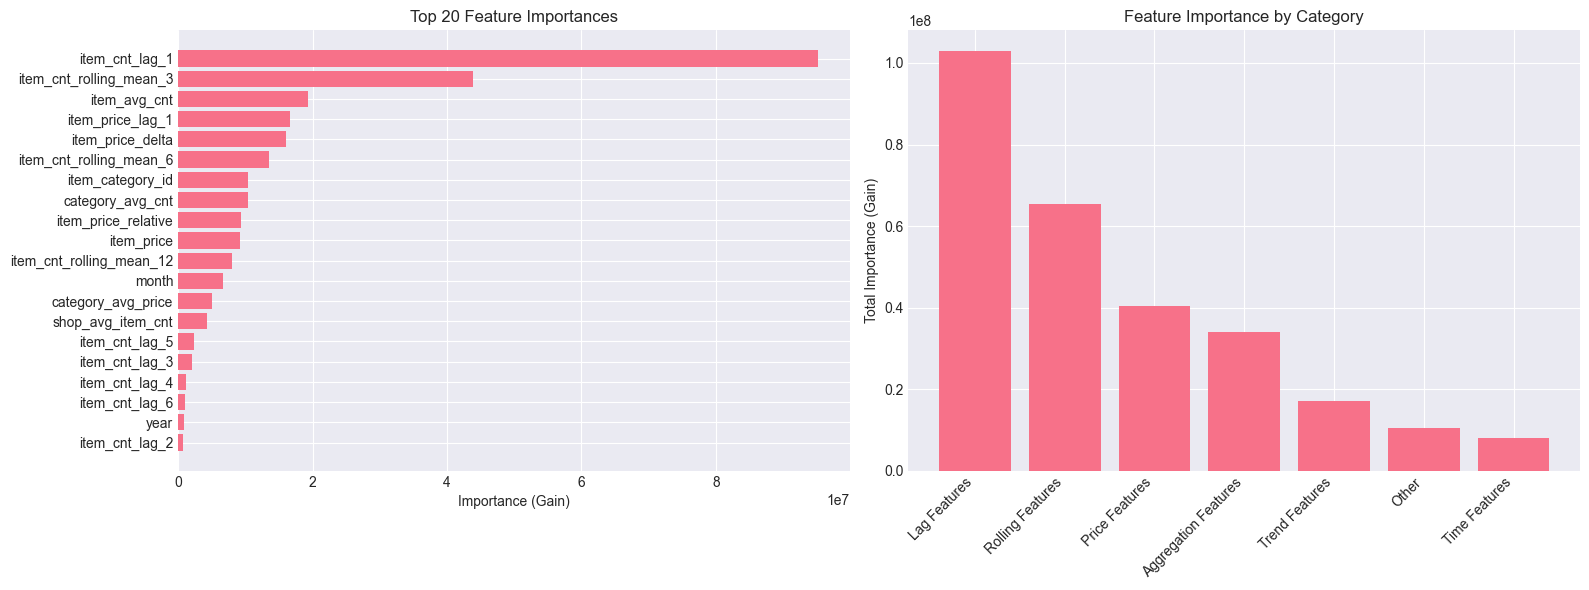


FEATURE CATEGORY IMPORTANCE:
Lag Features               102849381 ( 37.0%)
Rolling Features            65362557 ( 23.5%)
Price Features              40320064 ( 14.5%)
Aggregation Features        34052987 ( 12.2%)
Trend Features              17063815 (  6.1%)
Other                       10449930 (  3.8%)
Time Features                8031228 (  2.9%)


In [52]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("TOP 15 MOST IMPORTANT FEATURES:")
print("="*60)
for idx, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:30s} {row['importance']:>10.0f}")

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 features
top_n = 20
top_features = feature_importance.head(top_n)

axes[0].barh(range(len(top_features)), top_features['importance'])
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'])
axes[0].set_xlabel('Importance (Gain)')
axes[0].set_title(f'Top {top_n} Feature Importances')
axes[0].invert_yaxis()

# Feature importance by category
feature_importance['category'] = 'Other'
feature_importance.loc[feature_importance['feature'].str.contains('lag'), 'category'] = 'Lag Features'
feature_importance.loc[feature_importance['feature'].str.contains('rolling'), 'category'] = 'Rolling Features'
feature_importance.loc[feature_importance['feature'].str.contains('avg'), 'category'] = 'Aggregation Features'
feature_importance.loc[feature_importance['feature'].str.contains('price'), 'category'] = 'Price Features'
feature_importance.loc[feature_importance['feature'].str.contains('month|year|quarter'), 'category'] = 'Time Features'
feature_importance.loc[feature_importance['feature'].str.contains('delta|momentum'), 'category'] = 'Trend Features'

category_importance = feature_importance.groupby('category')['importance'].sum().sort_values(ascending=False)

axes[1].bar(range(len(category_importance)), category_importance.values)
axes[1].set_xticks(range(len(category_importance)))
axes[1].set_xticklabels(category_importance.index, rotation=45, ha='right')
axes[1].set_ylabel('Total Importance (Gain)')
axes[1].set_title('Feature Importance by Category')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FEATURE CATEGORY IMPORTANCE:")
print("="*60)
for cat, imp in category_importance.items():
    pct = imp / category_importance.sum() * 100
    print(f"{cat:25s} {imp:>10.0f} ({pct:>5.1f}%)")

* Các feature liên quan trực tiếp đến doanh số bán hàng của các tháng trước (Lag Features, Rolling Features) là quan trọng nhất trong việc đưa ra dự đoán doanh số cho tương lai

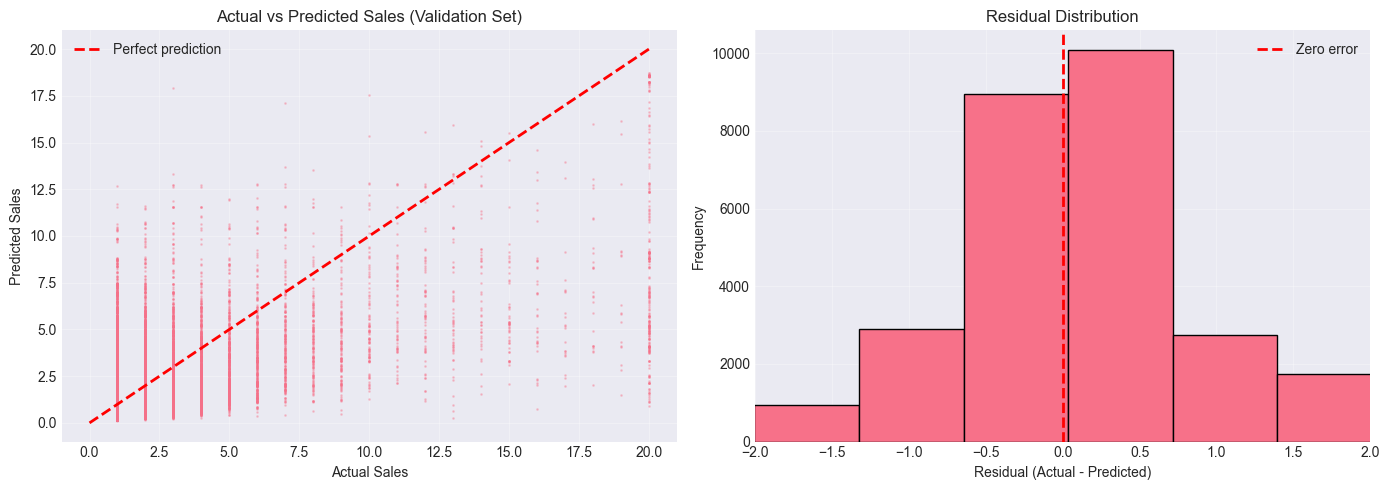

RESIDUAL ANALYSIS:
Mean residual: 0.2441
Std residual:  2.0564
Min residual:  -14.9290
Max residual:  19.0825


In [53]:
# Prediction distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_val, y_pred_lgb, alpha=0.3, s=1)
axes[0].plot([0, 20], [0, 20], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Sales')
axes[0].set_ylabel('Predicted Sales')
axes[0].set_title('Actual vs Predicted Sales (Validation Set)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual distribution
residuals = y_val - y_pred_lgb
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].axvline(0, color='r', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].set_xlim(-2, 2)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("RESIDUAL ANALYSIS:")
print("="*60)
print(f"Mean residual: {residuals.mean():.4f}")
print(f"Std residual:  {residuals.std():.4f}")
print(f"Min residual:  {residuals.min():.4f}")
print(f"Max residual:  {residuals.max():.4f}")

* Phân thích lỗi có thấy model có xu hướng dự đoán sales thấp hơn thực tế. Đây là điểm cần được phân tích để cải thiện trong tương lai

### 7.4 Save model

In [57]:
import os
import pickle
from datetime import datetime

# Create models directory if not exists
os.makedirs('models', exist_ok=True)

# Generate timestamp for model versioning
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save LightGBM model (native format - recommended)
model_path = f'models/lgb_sales_forecast_{timestamp}.txt'
model.save_model(model_path)
print(f"LightGBM model saved to: {model_path}")

# Save feature columns for inference
feature_cols_path = f'models/feature_columns_{timestamp}.pkl'
with open(feature_cols_path, 'wb') as f:
    pickle.dump(feature_cols, f)
print(f"Feature columns saved to: {feature_cols_path}")

# Save model metadata
metadata = {
    'timestamp': timestamp,
    'model_type': 'LightGBM',
    'best_iteration': model.best_iteration,
    'best_score_rmse': model.best_score['valid']['rmse'],
    'validation_metrics': {
        'rmse': rmse_lgb,
        'mae': mae_lgb,
        'r2': r2_lgb
    },
    'training_params': params,
    'feature_count': len(feature_cols),
    'training_samples': len(X_train_features),
    'validation_samples': len(X_val_features)
}

metadata_path = f'models/model_metadata_{timestamp}.pkl'
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"Model metadata saved to: {metadata_path}")

print("\n" + "="*60)
print("MODEL SAVED SUCCESSFULLY")
print("="*60)
print(f"Model file: {model_path}")
print(f"Features: {feature_cols_path}")
print(f"Metadata: {metadata_path}")

LightGBM model saved to: models/lgb_sales_forecast_20260210_000357.txt
Feature columns saved to: models/feature_columns_20260210_000357.pkl
Model metadata saved to: models/model_metadata_20260210_000357.pkl

MODEL SAVED SUCCESSFULLY
Model file: models/lgb_sales_forecast_20260210_000357.txt
Features: models/feature_columns_20260210_000357.pkl
Metadata: models/model_metadata_20260210_000357.pkl


## 8. Test Set Predictions

Generate predictions for the test set (November 2015, month 34). This involves:
1. Extending the sparse grid to include test pairs
2. Generating all features using historical data (months 0-33)
3. Making predictions with the trained model
4. Creating the final submission file

### 8.1 Extend Grid to Test Month

Extend the sparse grid to month 34 with test set (shop, item) pairs. Use the same sparse grid logic - only include pairs that had at least one sale during training OR appear in test set.

In [58]:
# Test month is 34
test_month = 34

# Get all test pairs
test_pairs_df = test_df[['shop_id', 'item_id']].copy()
test_pairs_df['date_block_num'] = test_month
test_pairs_df['item_cnt_month'] = np.nan  # Unknown target

print(f"\nTest set info:")
print(f"  Test month: {test_month}")
print(f"  Test pairs: {len(test_pairs_df):,}")

# Check overlap with training pairs
train_pair_set = set(zip(grid[grid['date_block_num'] < 34]['shop_id'], 
                          grid[grid['date_block_num'] < 34]['item_id']))
test_pair_set = set(zip(test_pairs_df['shop_id'], test_pairs_df['item_id']))

existing_pairs = train_pair_set & test_pair_set
new_pairs = test_pair_set - train_pair_set

print(f"\nTest pair analysis:")
print(f"  Existing pairs (in training): {len(existing_pairs):,} ({len(existing_pairs)/len(test_pair_set)*100:.1f}%)")
print(f"  New pairs (cold start): {len(new_pairs):,} ({len(new_pairs)/len(test_pair_set)*100:.1f}%)")

# Extend grid with test month
# For existing pairs: they already exist in grid up to their last_month, extend to month 34
# For new pairs: add them at month 34 only

print(f"\nExtending grid to month 34...")
grid_with_test = grid.copy()

# Append test pairs to grid
test_pairs_df = test_pairs_df.merge(items_df[['item_id', 'item_category_id']], on='item_id', how='left')

grid_with_test = pd.concat([grid_with_test, test_pairs_df], ignore_index=True)
print(f"Grid with test shape: {grid_with_test.shape}")

# Sort by shop, item, date for feature generation
grid_with_test = grid_with_test.sort_values(['shop_id', 'item_id', 'date_block_num']).reset_index(drop=True)

print(f"\nGrid extended to include test month")
print(f"  Total rows: {len(grid_with_test):,}")
print(f"  Rows for month 34: {len(grid_with_test[grid_with_test['date_block_num'] == 34]):,}")


Test set info:
  Test month: 34
  Test pairs: 214,200

Test pair analysis:
  Existing pairs (in training): 111,404 (52.0%)
  New pairs (cold start): 102,796 (48.0%)

Extending grid to month 34...
Grid with test shape: (3408635, 28)

Grid extended to include test month
  Total rows: 3,408,635
  Rows for month 34: 214,200


### 8.2 Generate Features for Test Set

Generate all features for month 34 using historical data from months 0-33. This includes:
- Lag features (from months 33, 32, 31, 28, 22)
- Rolling means (from historical windows)
- Aggregation features (shop/item/category averages from month 33)
- Trend and time features
- Price features

In [59]:
# Step 1: Lag features
print("\n1. Creating lag features...")
for lag in lag_periods:
    grid_with_test[f'item_cnt_lag_{lag}'] = grid_with_test.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)

lag_cols = [f'item_cnt_lag_{lag}' for lag in lag_periods]
grid_with_test[lag_cols] = grid_with_test[lag_cols].fillna(0)
print(f"Lag features: {lag_cols}")

# Step 2: Rolling mean features
print("\n2. Creating rolling mean features...")
for window in rolling_windows:
    grid_with_test[f'item_cnt_rolling_mean_{window}'] = (
        grid_with_test.groupby(['shop_id', 'item_id'])['item_cnt_month']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    )

rolling_cols = [f'item_cnt_rolling_mean_{w}' for w in rolling_windows]
grid_with_test[rolling_cols] = grid_with_test[rolling_cols].fillna(0)
print(f"Rolling mean features: {rolling_cols}")

# Step 3: Aggregated features (shop, item, category averages from previous month)
print("\n3. Creating aggregation features...")

# Shop-level aggregations
shop_agg = grid_with_test.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].mean().reset_index()
shop_agg.columns = ['date_block_num', 'shop_id', 'shop_avg_item_cnt']
shop_agg['date_block_num'] += 1
grid_with_test = grid_with_test.drop(columns=['shop_avg_item_cnt'], errors='ignore')
grid_with_test = grid_with_test.merge(shop_agg, on=['date_block_num', 'shop_id'], how='left')

# Item-level aggregations
item_agg = grid_with_test.groupby(['date_block_num', 'item_id'])['item_cnt_month'].mean().reset_index()
item_agg.columns = ['date_block_num', 'item_id', 'item_avg_cnt']
item_agg['date_block_num'] += 1
grid_with_test = grid_with_test.drop(columns=['item_avg_cnt'], errors='ignore')
grid_with_test = grid_with_test.merge(item_agg, on=['date_block_num', 'item_id'], how='left')

# Category-level aggregations
cat_agg = grid_with_test.groupby(['date_block_num', 'item_category_id'])['item_cnt_month'].mean().reset_index()
cat_agg.columns = ['date_block_num', 'item_category_id', 'category_avg_cnt']
cat_agg['date_block_num'] += 1
grid_with_test = grid_with_test.drop(columns=['category_avg_cnt'], errors='ignore')
grid_with_test = grid_with_test.merge(cat_agg, on=['date_block_num', 'item_category_id'], how='left')

agg_cols = ['shop_avg_item_cnt', 'item_avg_cnt', 'category_avg_cnt']
grid_with_test[agg_cols] = grid_with_test[agg_cols].fillna(0)
print(f"Aggregation features: {agg_cols}")

# Step 4: Trend features
print("\n4. Creating trend features...")
grid_with_test['item_cnt_delta_1'] = grid_with_test['item_cnt_lag_1'] - grid_with_test['item_cnt_lag_2']

# Create additional lags for momentum if needed
if 'item_cnt_lag_4' not in grid_with_test.columns:
    grid_with_test['item_cnt_lag_4'] = grid_with_test.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(4).fillna(0)
if 'item_cnt_lag_5' not in grid_with_test.columns:
    grid_with_test['item_cnt_lag_5'] = grid_with_test.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(5).fillna(0)

grid_with_test['item_cnt_momentum'] = (
    (grid_with_test['item_cnt_lag_1'] + grid_with_test['item_cnt_lag_2'] + grid_with_test['item_cnt_lag_3']) / 3 -
    (grid_with_test['item_cnt_lag_4'] + grid_with_test['item_cnt_lag_5'] + grid_with_test['item_cnt_lag_6']) / 3
)
print(f"Trend features: item_cnt_delta_1, item_cnt_momentum")

# Step 5: Time features
print("\n5. Creating time features...")
grid_with_test['month'] = (grid_with_test['date_block_num'] % 12) + 1
grid_with_test['year'] = 2013 + (grid_with_test['date_block_num'] // 12)
grid_with_test['quarter'] = ((grid_with_test['month'] - 1) // 3) + 1
print(f"Time features: month, year, quarter")

# Step 6: Price features
print("\n6. Creating price features...")

# Forward fill prices for test month (use last known price)
grid_with_test['item_price'] = grid_with_test.groupby(['shop_id', 'item_id'])['item_price'].fillna(method='ffill').fillna(method='bfill')

# If still NaN, use item's global mean price
grid_with_test['item_price'] = grid_with_test['item_price'].fillna(grid_with_test.groupby('item_id')['item_price'].transform('mean'))

# Price lag
grid_with_test['item_price_lag_1'] = grid_with_test.groupby(['shop_id', 'item_id'])['item_price'].shift(1)

# Price change
grid_with_test['item_price_delta'] = grid_with_test['item_price'] - grid_with_test['item_price_lag_1']

# Category average price
cat_price = grid_with_test.groupby(['date_block_num', 'item_category_id'])['item_price'].mean().reset_index()
cat_price.columns = ['date_block_num', 'item_category_id', 'category_avg_price']
cat_price['date_block_num'] += 1
grid_with_test = grid_with_test.drop(columns=['category_avg_price'], errors='ignore')
grid_with_test = grid_with_test.merge(cat_price, on=['date_block_num', 'item_category_id'], how='left')

# Price relative to category
grid_with_test['item_price_relative'] = grid_with_test['item_price'] / (grid_with_test['category_avg_price'] + 1)

# Fill NaN
grid_with_test[['item_price_lag_1', 'item_price_delta', 'category_avg_price', 'item_price_relative']] = \
    grid_with_test[['item_price_lag_1', 'item_price_delta', 'category_avg_price', 'item_price_relative']].fillna(0)

print(f"Price features: item_price, item_price_lag_1, item_price_delta, category_avg_price, item_price_relative")

print("\n" + "="*60)
print("ALL FEATURES GENERATED FOR TEST SET")
print("="*60)


1. Creating lag features...
Lag features: ['item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3', 'item_cnt_lag_6', 'item_cnt_lag_12']

2. Creating rolling mean features...
Rolling mean features: ['item_cnt_rolling_mean_3', 'item_cnt_rolling_mean_6', 'item_cnt_rolling_mean_12']

3. Creating aggregation features...
Aggregation features: ['shop_avg_item_cnt', 'item_avg_cnt', 'category_avg_cnt']

4. Creating trend features...
Trend features: item_cnt_delta_1, item_cnt_momentum

5. Creating time features...
Time features: month, year, quarter

6. Creating price features...
Price features: item_price, item_price_lag_1, item_price_delta, category_avg_price, item_price_relative

✓ ALL FEATURES GENERATED FOR TEST SET


### 8.3 Make Predictions

Extract test data (month 34) and generate predictions using the trained LightGBM model.

In [ ]:
print("="*60)
print("MAKING PREDICTIONS FOR TEST SET")
print("="*60)

# Extract test month data
X_test = grid_with_test[grid_with_test['date_block_num'] == 34].copy()

print(f"\nTest data extracted:")
print(f"  Rows: {len(X_test):,}")
print(f"  Shop-Item pairs: {X_test.groupby(['shop_id', 'item_id']).ngroups:,}")

# Prepare features (use same feature columns as training)
X_test_features = X_test[feature_cols].copy()

print(f"\nTest features shape: {X_test_features.shape}")

# Check for missing values
missing_test = X_test_features.isnull().sum().sum()
if missing_test > 0:
    print(f"\n⚠ Missing values detected: {missing_test}")
    print("Missing values by column:")
    print(X_test_features.isnull().sum()[X_test_features.isnull().sum() > 0])
    print("Filling with 0...")
    X_test_features = X_test_features.fillna(0)
else:
    print(f"✓ No missing values in test features")

# Make predictions
print(f"\nGenerating predictions with LightGBM model...")
y_pred_test = model.predict(X_test_features, num_iteration=model.best_iteration)

# Clip predictions to valid range [0, 20]
y_pred_test = np.clip(y_pred_test, 0, 20)

print(f"Predictions generated!")

# Create final test predictions dataframe by merging with test_df
final_test_pred_df = test_df[['ID', 'shop_id', 'item_id']].copy()

# Create mapping from (shop_id, item_id) to prediction
X_test['item_cnt_month'] = y_pred_test
prediction_map = X_test.set_index(['shop_id', 'item_id'])['item_cnt_month'].to_dict()

# Map predictions to test set
final_test_pred_df['item_cnt_month'] = final_test_pred_df.apply(
    lambda row: prediction_map.get((row['shop_id'], row['item_id']), 0), 
    axis=1
)


display(final_test_pred_df.head(10))


